In [158]:
import torch
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import os
import matplotlib.pyplot as plt

os.listdir('../input/')

['data.csv']

In [159]:
data = pd.read_csv('../input/data.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [160]:
cols = data.columns
x_data = data[cols[2:-1]]
print(len(cols))
x_data.head()

33


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [161]:
y_data = data[cols[1]]
le = LabelEncoder()
y_data = np.array(le.fit_transform(y_data))
y_data[:5], le.classes_

(array([1, 1, 1, 1, 1]), array(['B', 'M'], dtype=object))

In [162]:
y_data.shape, x_data.values.shape

((569,), (569, 30))

In [163]:
x_data = Variable(torch.from_numpy(x_data.values))
y_data = Variable(torch.from_numpy(y_data))


In [164]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(30,16)
        self.l2 = torch.nn.Linear(16,4)
        self.l3 = torch.nn.Linear(4,1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) 
        out2 = self.sigmoid(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred
    
model = Model()

In [165]:
x_data.float().size(), y_data.float().size()

(torch.Size([569, 30]), torch.Size([569]))

In [166]:
criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses=[]
for epochs in range(500):
    y_pred = model(x_data.float())
    loss = criterion(y_pred, y_data.view(-1,1).float())
    print('Epoch',epochs,'Loss:',loss.item(), '- Pred:', y_pred.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss)

Epoch 0 Loss: 398.5055847167969 - Pred: tensor([0.5201])
Epoch 1 Loss: 398.0128479003906 - Pred: tensor([0.5190])
Epoch 2 Loss: 397.624267578125 - Pred: tensor([0.5179])
Epoch 3 Loss: 397.23760986328125 - Pred: tensor([0.5167])
Epoch 4 Loss: 396.817138671875 - Pred: tensor([0.5156])
Epoch 5 Loss: 396.4052429199219 - Pred: tensor([0.5145])
Epoch 6 Loss: 396.0176086425781 - Pred: tensor([0.5134])
Epoch 7 Loss: 395.6388854980469 - Pred: tensor([0.5123])
Epoch 8 Loss: 395.2536926269531 - Pred: tensor([0.5112])
Epoch 9 Loss: 394.8626403808594 - Pred: tensor([0.5101])
Epoch 10 Loss: 394.4717712402344 - Pred: tensor([0.5090])
Epoch 11 Loss: 394.0920715332031 - Pred: tensor([0.5077])
Epoch 12 Loss: 393.7176818847656 - Pred: tensor([0.5055])
Epoch 13 Loss: 393.3384094238281 - Pred: tensor([0.5035])
Epoch 14 Loss: 392.94720458984375 - Pred: tensor([0.5024])
Epoch 15 Loss: 392.5501403808594 - Pred: tensor([0.5013])
Epoch 16 Loss: 392.1274719238281 - Pred: tensor([0.5003])
Epoch 17 Loss: 391.69970

In [167]:
x_data.data[0]

tensor([1.7990e+01, 1.0380e+01, 1.2280e+02, 1.0010e+03, 1.1840e-01, 2.7760e-01,
        3.0010e-01, 1.4710e-01, 2.4190e-01, 7.8710e-02, 1.0950e+00, 9.0530e-01,
        8.5890e+00, 1.5340e+02, 6.3990e-03, 4.9040e-02, 5.3730e-02, 1.5870e-02,
        3.0030e-02, 6.1930e-03, 2.5380e+01, 1.7330e+01, 1.8460e+02, 2.0190e+03,
        1.6220e-01, 6.6560e-01, 7.1190e-01, 2.6540e-01, 4.6010e-01, 1.1890e-01],
       dtype=torch.float64)

In [168]:
model.double().forward(x_data.data[25]) > 0.5, y_data[25]

(tensor([1], dtype=torch.uint8), tensor(1))

In [169]:
model.double().forward(x_data.data[55]) > 0.5, y_data[55]

(tensor([0], dtype=torch.uint8), tensor(0))

In [170]:
pred = model.double().forward(x_data) > 0.5
pred.numpy()[:5]

array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=uint8)

In [171]:
a = pred.numpy()
b = y_data.numpy()
pred.numpy().reshape(-1).shape, y_data.numpy().shape

((569,), (569,))

## Score Metrics Report

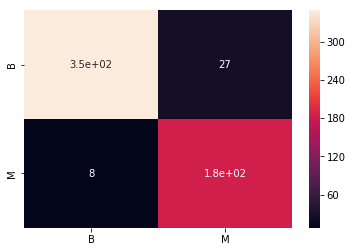

In [172]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
c = confusion_matrix(a,b)
sns.heatmap(c, annot=True, xticklabels=le.classes_, yticklabels=le.classes_);

In [173]:
print(classification_report(a,b))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       376
           1       0.87      0.96      0.91       193

   micro avg       0.94      0.94      0.94       569
   macro avg       0.93      0.94      0.93       569
weighted avg       0.94      0.94      0.94       569



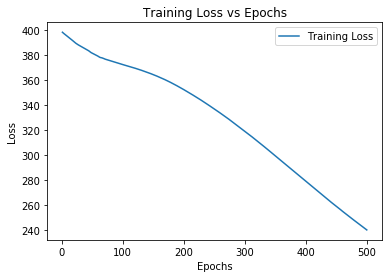

In [174]:
plt.plot(range(1, 500 + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

57
------
57


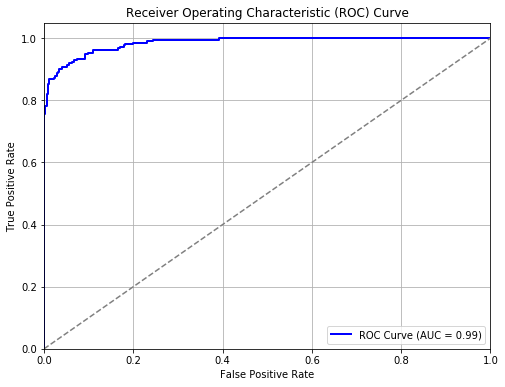

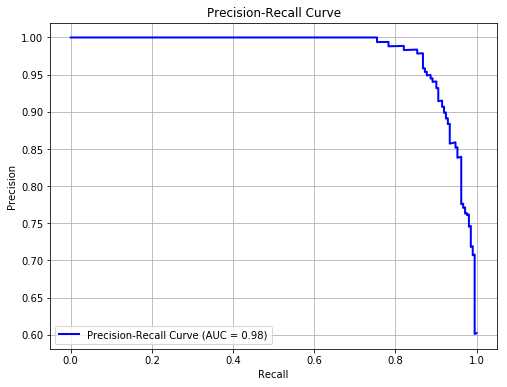

In [175]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Make predictions
pred = (model.double().forward(x_data) ).detach().numpy()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_data.numpy(), pred)
roc_auc = auc(fpr, tpr)
print(len(fpr))
print("------")
print(len(tpr))
# Compute precision-recall curve and area under the curve
precision, recall, _ = precision_recall_curve(y_data.numpy(), pred)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


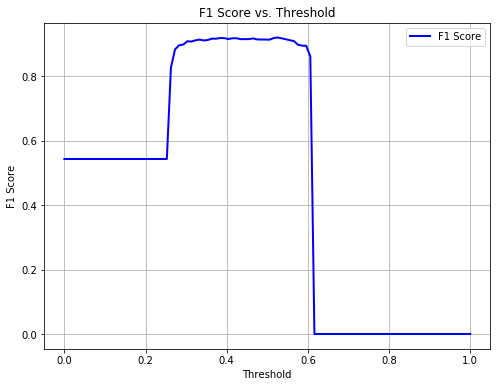

In [176]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Compute F1 score for different threshold values
thresholds = np.linspace(0, 1, 100)
f1_scores = []
for threshold in thresholds:
    pred_thresholded = (pred >= threshold).astype(int)
    if pred_thresholded.sum() > 0:  # Check if there are any positive predictions
        f1_scores.append(f1_score(y_data.numpy(), pred_thresholded))
    else:
        f1_scores.append(0.0)  # Set F1 score to 0 if no positive predictions

# Plot F1 score with respect to different threshold values
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, color='blue', lw=2, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()
